In [5]:
#Иллюстративный код
# Полный код для EDA анализа e-commerce данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

# Настройки визуализации
sns.set_theme(style="whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [6]:
class EDAProcessor:
# Класс для проведения комплексного EDA анализа

    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self.numerical_cols = []
        self.categorical_cols = []
        self.datetime_cols = []

    def initial_exploration(self):
        #"""Первичное исследование данных"""
        print("=" * 50)
        print("ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ")
        print("=" * 50)

        print(f"Размер: {self.data.shape}")
        print(f"\nИнформация о данных:")
        print(self.data.info())

        print(f"\nСтатистика числовых данных:")
        print(self.data.describe())

        print(f"\nСтатистика категориальных данных:")
        print(self.data.describe(include=['object']))

    def identify_column_types(self):
        #"""Идентификация типов колонок"""
        self.numerical_cols = self.data.select_dtypes(include=[np.number]).columns.tolist()
        self.categorical_cols = self.data.select_dtypes(include=['object']).columns.tolist()
        self.datetime_cols = self.data.select_dtypes(include=['datetime64']).columns.tolist()

        # Попытка автоматического преобразования в datetime
        for col in self.data.columns:
            if self.data[col].dtype == 'object':
                try:
                    self.data[col] = pd.to_datetime(self.data[col])
                    self.datetime_cols.append(col)
                    self.categorical_cols.remove(col)
                except:
                    pass

        print(f"\nТипы колонок:")
        print(f"Числовые: {self.numerical_cols}")
        print(f"Категориальные: {self.categorical_cols}")
        print(f"Дата/время: {self.datetime_cols}")

    def analyze_missing_values(self):
       #  """Анализ пропущенных значений"""
        print("=" * 50)
        print("АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
        print("=" * 50)

        missing_data = self.data.isnull().sum()
        missing_percent = (missing_data / len(self.data)) * 100

        missing_df = pd.DataFrame({
            'missing_count': missing_data,
            'missing_percent': missing_percent
        }).sort_values('missing_percent', ascending=False)

        print(missing_df[missing_df['missing_count'] > 0])

        # Визуализация пропущенных значений
        if missing_df[missing_df['missing_count'] > 0].shape[0] > 0:
            plt.figure(figsize=(10, 6))
            sns.heatmap(self.data.isnull(), cbar=False, cmap='viridis')
            plt.title('Карта пропущенных значений')
            plt.show()

    def analyze_numerical_distributions(self):

        # Анализ распределений числовых переменных

        print("=" * 50)
        print("АНАЛИЗ РАСПРЕДЕЛЕНИЙ ЧИСЛОВЫХ ПЕРЕМЕННЫХ")
        print("=" * 50)

        for col in self.numerical_cols:
            print(f"\nАнализ переменной: {col}")
            print(f"Медиана: {self.data[col].median():.2f}")
            print(f"Среднее: {self.data[col].mean():.2f}")
            print(f"Стандартное отклонение: {self.data[col].std():.2f}")
            print(f"Асимметрия: {self.data[col].skew():.2f}")
            print(f"Эксцесс: {self.data[col].kurtosis():.2f}")

            # Визуализация распределения
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))

            # Гистограмма с KDE
            sns.histplot(self.data[col], kde=True, ax=axes[0])
            axes[0].set_title(f'Распределение {col}')
            axes[0].set_xlabel(col)

            # Boxplot
            sns.boxplot(y=self.data[col], ax=axes[1])
            axes[1].set_title(f'Boxplot {col}')

            plt.tight_layout()
            plt.show()

    def analyze_categorical_distributions(self):
        # Анализ категориальных переменных"""
        print("=" * 50)
        print("АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ")
        print("=" * 50)

        for col in self.categorical_cols:
            print(f"\nАнализ переменной: {col}")
            value_counts = self.data[col].value_counts()
            print(f"Уникальных значений: {self.data[col].nunique()}")
            print(f"Топ-5 значений:")
            print(value_counts.head())

            # Визуализация
            if self.data[col].nunique() <= 20:
                plt.figure(figsize=(10, 6))
                if self.data[col].nunique() > 10:
                    # Для многих категорий показываем топ-10
                    top_10 = value_counts.head(10)
                    sns.barplot(x=top_10.values, y=top_10.index)
                else:
                    sns.countplot(y=self.data[col], order=value_counts.index)

                plt.title(f'Распределение {col}')
                plt.xlabel('Количество')
                plt.tight_layout()
                plt.show()

    def analyze_correlations(self):
        # Анализ корреляций между переменными"""
        print("=" * 50)
        print("АНАЛИЗ КОРРЕЛЯЦИЙ")
        print("=" * 50)

        if len(self.numerical_cols) > 1:
            correlation_matrix = self.data[self.numerical_cols].corr()

            print("Матрица корреляций:")
            print(correlation_matrix)

            # Визуализация heatmap
            plt.figure(figsize=(12, 8))
            mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
            sns.heatmap(correlation_matrix,
                        mask=mask,
                        annot=True,
                        cmap='coolwarm',
                        center=0,
                        square=True,
                        fmt='.2f')
            plt.title('Матрица корреляций числовых переменных')
            plt.show()

            # Анализ сильных корреляций
            strong_correlations = []
            for i in range(len(correlation_matrix.columns)):
                for j in range(i+1, len(correlation_matrix.columns)):
                    if abs(correlation_matrix.iloc[i, j]) > 0.7:
                        strong_correlations.append((
                            correlation_matrix.columns[i],
                            correlation_matrix.columns[j],
                            correlation_matrix.iloc[i, j]
                        ))

            if strong_correlations:
                print("\nСильные корреляции (|r| > 0.7):")
                for corr in strong_correlations:
                  print(f"{corr[0]} - {corr[1]}: {corr[2]:.2f}")

    def analyze_time_series(self):
        #        """Анализ временных рядов"""
        if self.datetime_cols:
            print("=" * 50)
            print("АНАЛИЗ ВРЕМЕННЫХ РЯДОВ")
            print("=" * 50)

            for date_col in self.datetime_cols:
                print(f"\nАнализ временного ряда: {date_col}")

                # Создание временных признаков
                self.data[f'{date_col}_year'] = self.data[date_col].dt.year
                self.data[f'{date_col}_month'] = self.data[date_col].dt.month
                self.data[f'{date_col}_day'] = self.data[date_col].dt.day
                self.data[f'{date_col}_dayofweek'] = self.data[date_col].dt.dayofweek

                # Агрегация по времени
                time_agg = self.data.groupby(date_col).size()

                # Визуализация
                plt.figure(figsize=(15, 6))
                time_agg.plot()
                plt.title(f'Динамика количества событий по времени ({date_col})')
                plt.xlabel('Дата')
                plt.ylabel('Количество событий')
                plt.grid(True)
                plt.show()

                # Сезонность по дням недели
                if f'{date_col}_dayofweek' in self.data.columns:
                    dow_agg = self.data.groupby(f'{date_col}_dayofweek').size()
                    plt.figure(figsize=(10, 6))
                    dow_agg.plot(kind='bar')
                    plt.title('Распределение по дням недели')
                    plt.xlabel('День недели')
                    plt.ylabel('Количество событий')
                    plt.xticks(rotation=0)
                    plt.show()

    def detect_outliers(self):
        #       """Обнаружение выбросов"""
        print("=" * 50)
        print("ДЕТЕКЦИЯ ВЫБРОСОВ")
        print("=" * 50)

        for col in self.numerical_cols:
            # Метод IQR
            Q1 = self.data[col].quantile(0.25)
            Q3 = self.data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = self.data[(self.data[col] < lower_bound) | (self.data[col] > upper_bound)]
            outlier_percent = (len(outliers) / len(self.data)) * 100

            print(f"\nПеременная: {col}")
            print(f"Выбросов (IQR метод): {len(outliers)} ({outlier_percent:.2f}%)")

            if len(outliers) > 0:
                print(f"Примеры выбросов: {outliers[col].values[:5]}")

    def generate_insights(self):
        #      """Генерация автоматических инсайтов"""
        print("=" * 50)
        print("АВТОМАТИЧЕСКИЕ ИНСАЙТЫ")
        print("=" * 50)

        insights = []

        # Анализ числовых переменных
        for col in self.numerical_cols:
            skewness = self.data[col].skew()
            if abs(skewness) > 1:
                insight = f"Переменная {col} имеет сильную асимметрию ({skewness:.2f})"
                insights.append(insight)
                print(insight)

        # Анализ корреляций
        if len(self.numerical_cols) > 1:
            corr_matrix = self.data[self.numerical_cols].corr()
            for i in range(len(corr_matrix.columns)):
                for j in range(i+1, len(corr_matrix.columns)):
                    if abs(corr_matrix.iloc[i, j]) > 0.7:
                        insight = f"Сильная корреляция между {corr_matrix.columns[i]} и {corr_matrix.columns[j]}: {corr_matrix.iloc[i, j]:.2f}"
                        insights.append(insight)
                        print(insight)

        return insights

    def create_comprehensive_report(self):
     # Создание комплексного отчета
        self.initial_exploration()
        self.identify_column_types()
        self.analyze_missing_values()
        self.analyze_numerical_distributions()
        self.analyze_categorical_distributions()
        self.analyze_correlations()
        self.analyze_time_series()
        self.detect_outliers()
        insights = self.generate_insights()

        return insights


In [7]:
filePath = "D:\\hse_master\\Прикладная наука о данных\\project\\data\\raw\\Bank\\Bank Customer Churn Prediction.csv"
filePath

'D:\\hse_master\\Прикладная наука о данных\\project\\data\\raw\\Bank\\Bank Customer Churn Prediction.csv'

ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ
Размер: (10000, 12)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB
None

Статистика числовых данных:
        customer_id  credit_score           age        tenure        b

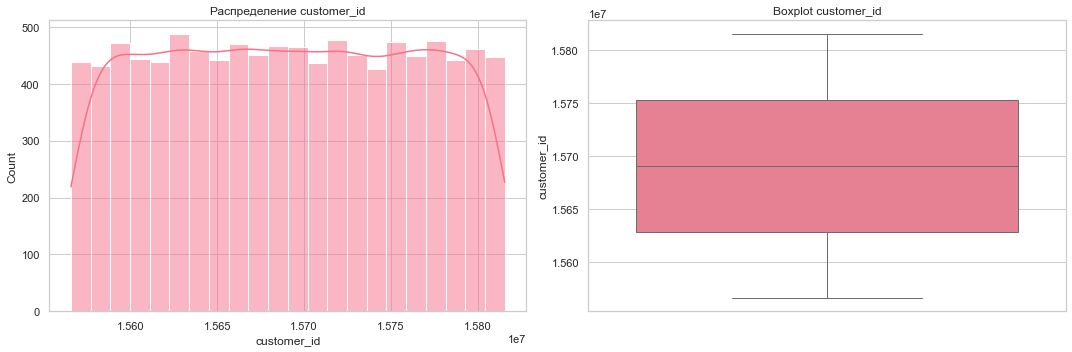


Анализ переменной: credit_score
Медиана: 652.00
Среднее: 650.53
Стандартное отклонение: 96.65
Асимметрия: -0.07
Эксцесс: -0.43


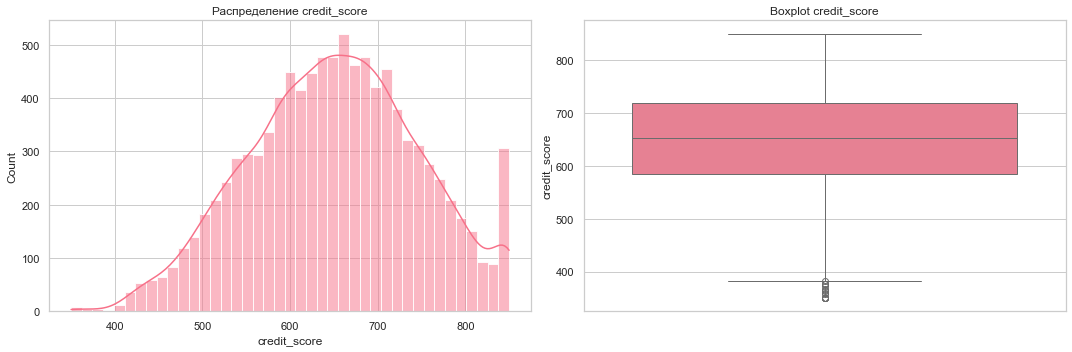


Анализ переменной: age
Медиана: 37.00
Среднее: 38.92
Стандартное отклонение: 10.49
Асимметрия: 1.01
Эксцесс: 1.40


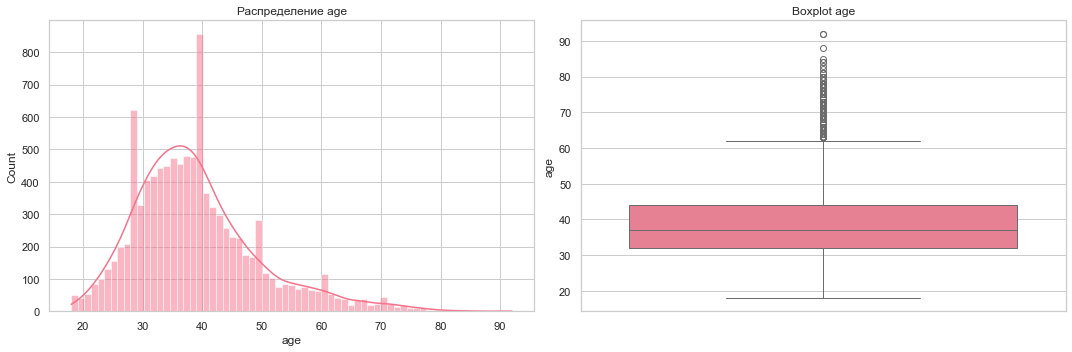


Анализ переменной: tenure
Медиана: 5.00
Среднее: 5.01
Стандартное отклонение: 2.89
Асимметрия: 0.01
Эксцесс: -1.17


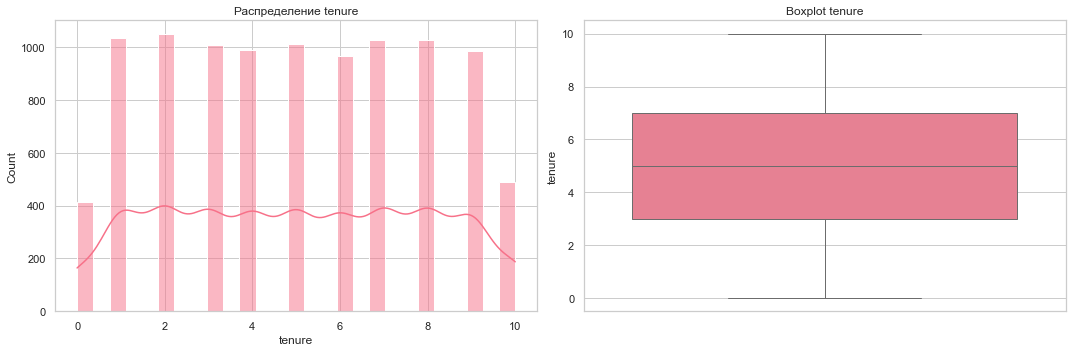


Анализ переменной: balance
Медиана: 97198.54
Среднее: 76485.89
Стандартное отклонение: 62397.41
Асимметрия: -0.14
Эксцесс: -1.49


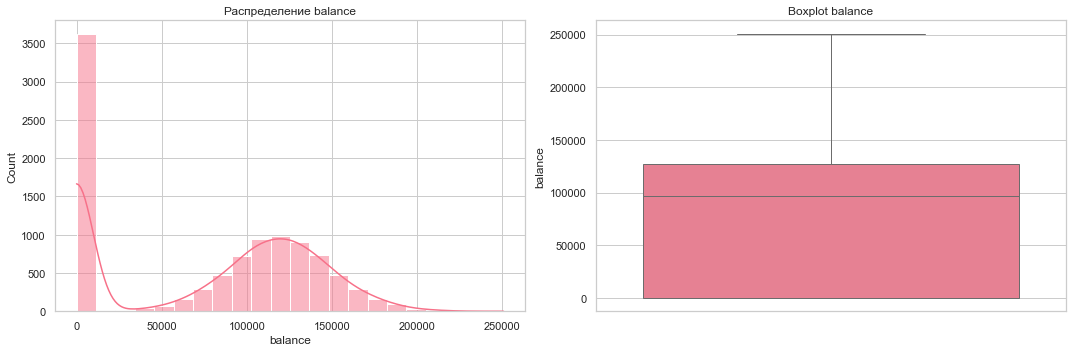


Анализ переменной: products_number
Медиана: 1.00
Среднее: 1.53
Стандартное отклонение: 0.58
Асимметрия: 0.75
Эксцесс: 0.58


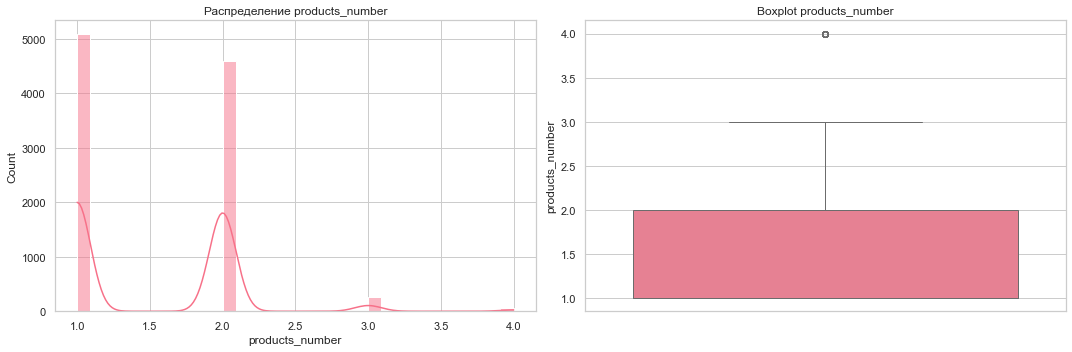


Анализ переменной: credit_card
Медиана: 1.00
Среднее: 0.71
Стандартное отклонение: 0.46
Асимметрия: -0.90
Эксцесс: -1.19


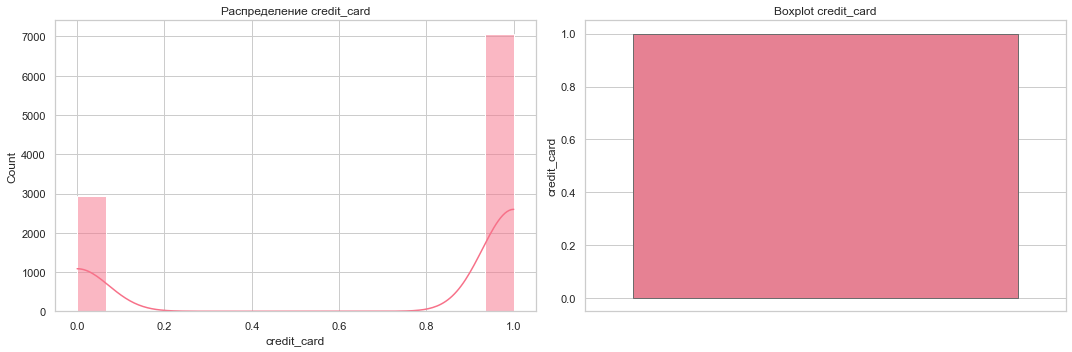


Анализ переменной: active_member
Медиана: 1.00
Среднее: 0.52
Стандартное отклонение: 0.50
Асимметрия: -0.06
Эксцесс: -2.00


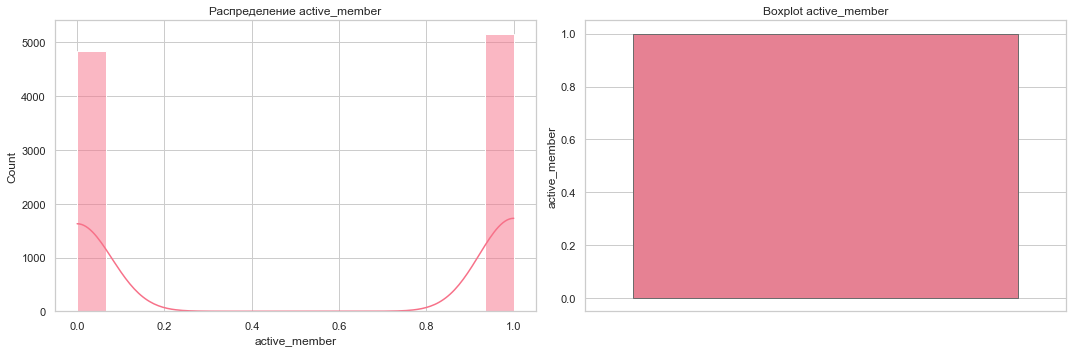


Анализ переменной: estimated_salary
Медиана: 100193.91
Среднее: 100090.24
Стандартное отклонение: 57510.49
Асимметрия: 0.00
Эксцесс: -1.18


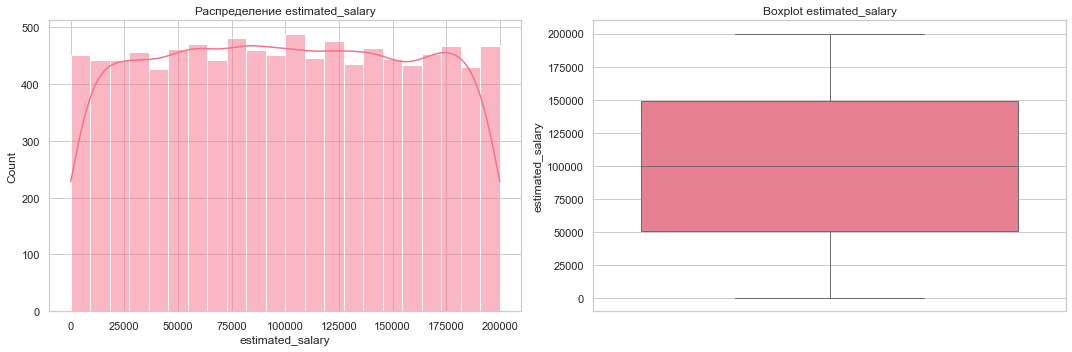


Анализ переменной: churn
Медиана: 0.00
Среднее: 0.20
Стандартное отклонение: 0.40
Асимметрия: 1.47
Эксцесс: 0.17


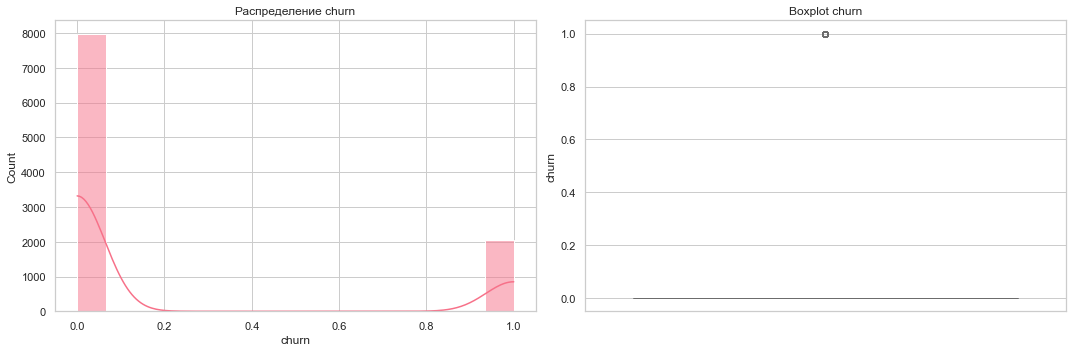

АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ

Анализ переменной: country
Уникальных значений: 3
Топ-5 значений:
country
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64


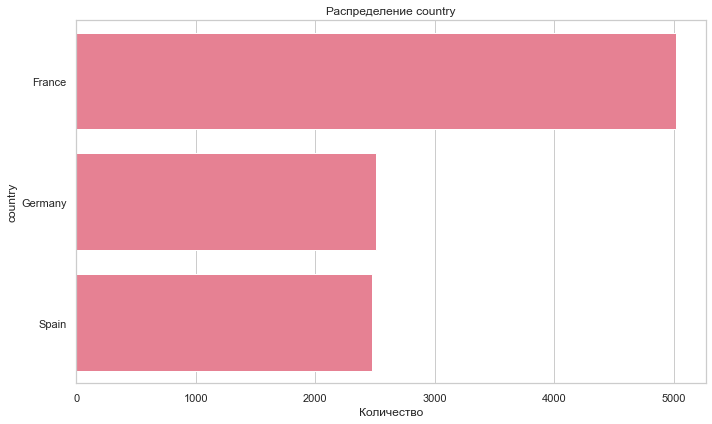


Анализ переменной: gender
Уникальных значений: 2
Топ-5 значений:
gender
Male      5457
Female    4543
Name: count, dtype: int64


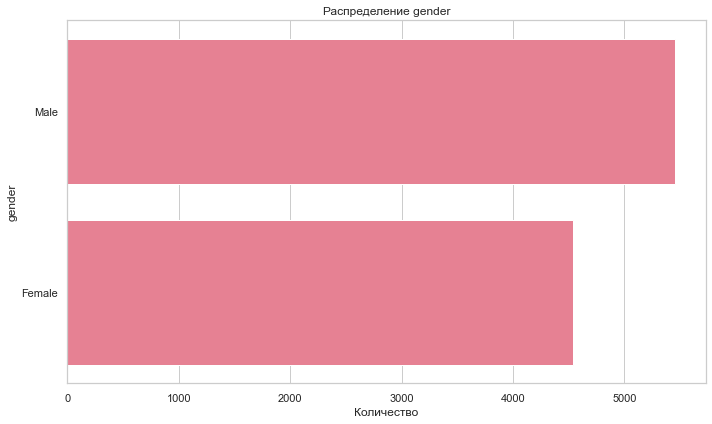

АНАЛИЗ КОРРЕЛЯЦИЙ
Матрица корреляций:
                  customer_id  credit_score       age    tenure   balance  products_number  credit_card  active_member  estimated_salary     churn
customer_id          1.000000      0.005308  0.009497 -0.014883 -0.012419         0.016972    -0.014025       0.001665          0.015271 -0.006248
credit_score         0.005308      1.000000 -0.003965  0.000842  0.006268         0.012238    -0.005458       0.025651         -0.001384 -0.027094
age                  0.009497     -0.003965  1.000000 -0.009997  0.028308        -0.030680    -0.011721       0.085472         -0.007201  0.285323
tenure              -0.014883      0.000842 -0.009997  1.000000 -0.012254         0.013444     0.022583      -0.028362          0.007784 -0.014001
balance             -0.012419      0.006268  0.028308 -0.012254  1.000000        -0.304180    -0.014858      -0.010084          0.012797  0.118533
products_number      0.016972      0.012238 -0.030680  0.013444 -0.304180       

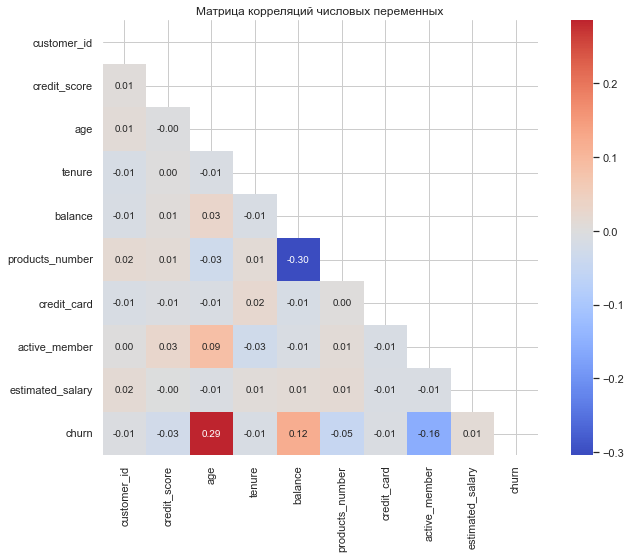

ДЕТЕКЦИЯ ВЫБРОСОВ

Переменная: customer_id
Выбросов (IQR метод): 0 (0.00%)

Переменная: credit_score
Выбросов (IQR метод): 15 (0.15%)
Примеры выбросов: [376 376 363 359 350]

Переменная: age
Выбросов (IQR метод): 359 (3.59%)
Примеры выбросов: [66 75 65 73 65]

Переменная: tenure
Выбросов (IQR метод): 0 (0.00%)

Переменная: balance
Выбросов (IQR метод): 0 (0.00%)

Переменная: products_number
Выбросов (IQR метод): 60 (0.60%)
Примеры выбросов: [4 4 4 4 4]

Переменная: credit_card
Выбросов (IQR метод): 0 (0.00%)

Переменная: active_member
Выбросов (IQR метод): 0 (0.00%)

Переменная: estimated_salary
Выбросов (IQR метод): 0 (0.00%)

Переменная: churn
Выбросов (IQR метод): 2037 (20.37%)
Примеры выбросов: [1 1 1 1 1]
АВТОМАТИЧЕСКИЕ ИНСАЙТЫ
Переменная age имеет сильную асимметрию (1.01)
Переменная churn имеет сильную асимметрию (1.47)

АНАЛИЗ ЗАВЕРШЕН
Сгенерировано инсайтов: 2


In [9]:
# Использование класса
name = "main"
if name == "main":
    # Инициализация процессора

    processor = EDAProcessor(filePath)

    # Запуск комплексного анализа
    insights = processor.create_comprehensive_report()

    # Сохранение отчета
    report_data = {
        'dataset_shape': processor.data.shape,
        'numerical_columns': processor.numerical_cols,
        'categorical_columns': processor.categorical_cols,
        'datetime_columns': processor.datetime_cols,
        'insights': insights
    }

    print("\n" + "="*50)
    print("АНАЛИЗ ЗАВЕРШЕН")
    print("="*50)
    print(f"Сгенерировано инсайтов: {len(insights)}")